In [1]:
import yaml
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scatseisnet import ScatteringNetwork
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.gridspec import GridSpec
from obspy.core import UTCDateTime
from obspy import Stream, Trace
from matplotlib import dates as mdates
InteractiveShell.ast_node_interactivity = "all" 
plt.style.use('ggplot')

`yaml` file: 
```
data:
    load:
        repository: F:/  
        events: ALL  
    save: 
        filename: data.npy  
    target_site: NMEH

filter:
    start: 726    
    end: 750
    n_stations: 1 
    n_channels: 3  

processing:
    seg_duration: 60.0
    sampling_freq: 100.0
    n_components: 10

clustering:
    N_CLUSTERS: 10
    N_WAVEFORMS: 5

```

In [27]:
# Load the YAML configuration file
with open("example.yaml", "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

# Get the data repository and file names
data_repository = config['data']['load']['repository']
events = config['data']['load']['events']
save_filename = config['data']['save']['filename']
target_site = config['data']['target_site']

# Get the filter parameters
start_hour = config['filter']['start']
end_hour = config['filter']['end']
n_stations = config['filter']['n_stations']
n_channels = config['filter']['n_channels']

# Get processing parameters
seg_duration = config['processing']['seg_duration']
sampling_freq = config['processing']['sampling_freq']
n_components = config['processing']['n_components']

# Get clustering parameters
N_CLUSTERS = config['clustering']['N_CLUSTERS']
N_WAVEFORMS = config['clustering']['N_WAVEFORMS']


In [29]:
path = data_repository 
files = os.listdir(path)
sites = []

for file in files:
    if file.endswith('.h5'):
        dir=os.path.join(path,file)
        f = h5py.File(dir, 'r')
        sites.append(pd.DataFrame(list(f.keys()), columns=[file]))

df = pd.concat(sites, axis=1)

df

ev0000593283.h5 ev0000734973.h5 ev0000773200.h5 ev0001903830.h5   
0             AIRH            AIOH            BTOH            CHKH  \
1             AKIH            AKSH            DGOH            FGTH   
2             AKNH            AMNH            FKSH            FKSH   
3             ASKH            AYKH            GZNH            FSWH   
4             BZNH            BSEH            HTAH            HMNH   
..             ...             ...             ...             ...   
70            UWEH             NaN             NaN             NaN   
71            WKMH             NaN             NaN             NaN   
72            YABH             NaN             NaN             NaN   
73            YGNH             NaN             NaN             NaN   
74            YMGH             NaN             NaN             NaN   

   ev0002128689.h5 ev0000364000.h5  
0             AKIH            IWEH  
1             AS2H            KI2H  
2             ASKH            MKJH  
3             BZNH            NMEH  
4             GKSH             NaN  
..             ...             ...  
70             NaN             NaN  
71             NaN             NaN  
72             NaN             NaN  
73             NaN             NaN  
74             NaN             NaN  

[75 rows x 6 columns]

In [30]:
# Count the number of times each site appears in all events
counts = df.stack().value_counts()
counts

NMEH    3
MKJH    3
MSMH    2
SNIH    2
MISH    2
       ..
NNMH    1
KKIH    1
KAMH    1
MSRH    1
WKMH    1
Name: count, Length: 231, dtype: int64

In [31]:
target_site = target_site

# Find the h5 files that contain the 'NMEH' site
files_with_target = df.columns[df.isin([target_site]).any()].tolist()
event_times = []

# Read the h5 files that contain the 'NMEH' site
for file in files_with_target:
    dir = os.path.join(path, file)
    f = h5py.File(dir, 'r')
    
    data = f[target_site]  # Extract data for the NMEH site
    event_times.append(f.attrs['time'])  # Extract the timestamp
    
    # At this point, you can process the data, e.g., print it, save it elsewhere, etc.
    print(dir, f.attrs['time'])


F:/ev0000773200.h5 2016-11-21T20:59:46.890000Z
F:/ev0001903830.h5 2021-03-20T09:09:44.830000Z
F:/ev0000364000.h5 2014-07-11T19:22:00.440000Z


In [32]:
# Convert hours to sample indices
start_index = int(start_hour * 3600 * 100)
end_index = int(end_hour * 3600 * 100)

# Initialize the data array with an additional dimension for the distance
data = np.empty((len(files_with_target), n_stations, n_channels, end_index - start_index))

np.save(save_filename, data)

In [33]:
i=0
for file in files_with_target:
    dir=os.path.join(path,file)
    f = h5py.File(dir, 'r')
    data[i,0,:,:] = f[target_site][:,start_index:end_index] # data[i,,,] i-th event 
    i=i+1

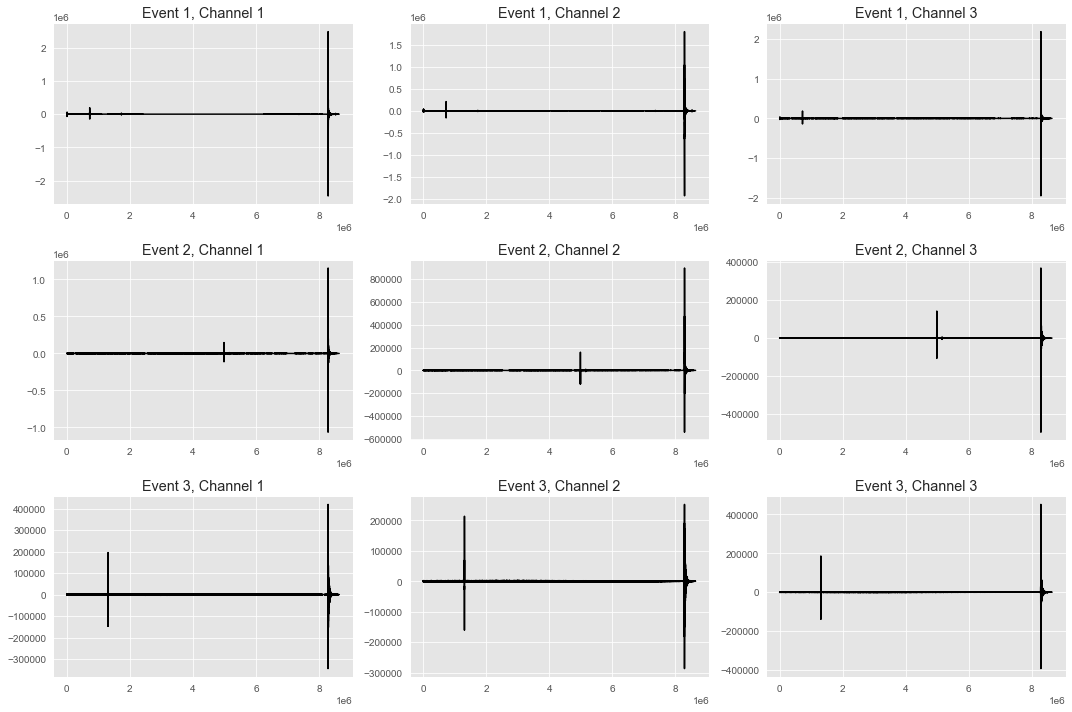

In [34]:
%matplotlib inline
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

for i in range(3): 
    for j in range(3): 
        _=ax[i, j].plot(data[i, 0, j, :], 'k-');
        _=ax[i, j].set_title(f'Event {i+1}, Channel {j+1}');

plt.tight_layout()
plt.show();

ScatteringNetwork(bins=6000, sampling_rate=100.0, len=2)
ComplexMorletBank(bins=6000, octaves=4, resolution=4, quality=1, sampling_rate=100.0, len=16)
ComplexMorletBank(bins=6000, octaves=5, resolution=2, quality=3, sampling_rate=100.0, len=10)


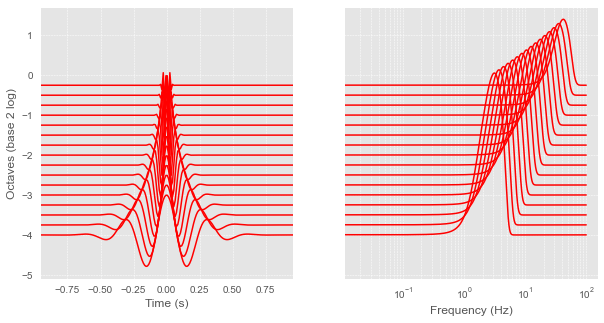

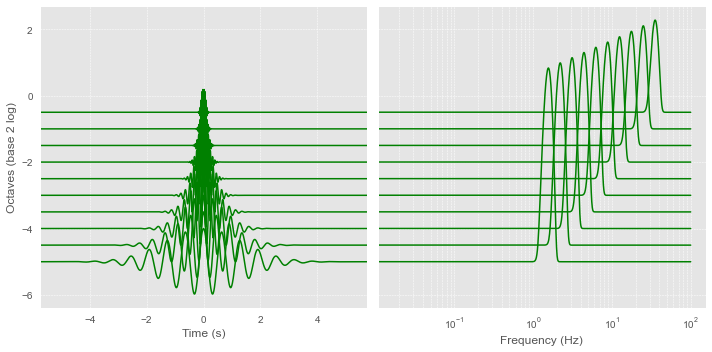

In [35]:
# Settings
seg_duration = seg_duration
sampling_freq = sampling_freq
num_samples = int(seg_duration * sampling_freq)
bank_params = [
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
]

# Initialize ScatteringNetwork
network = ScatteringNetwork(
    *bank_params,
    bins=num_samples,
    sampling_rate=sampling_freq,
)
print(scattering_net)

# Visualization
colors = ["red", "green"]

for idx, bank_obj in enumerate(network.banks):
    fig, ax_arr = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    color = colors[idx]

    for wv, sp, rt in zip(bank_obj.wavelets, bank_obj.spectra, bank_obj.ratios):
        _=ax_arr[0].plot(bank_obj.times, wv.real + rt, color=color);
        _=ax_arr[1].plot(bank_obj.frequencies, np.log1p(np.abs(sp)) + rt, color=color);

    max_width = 3 * bank_obj.widths.max()
    _=ax_arr[0].set(ylabel="Octaves (base 2 log)", xlabel="Time (s)", xlim=(-max_width, max_width));
    _=ax_arr[1].set(xscale="log", xlabel="Frequency (Hz)");
    _=ax_arr[0].grid(True, which='both', linestyle='--', linewidth=0.5);
    _=ax_arr[1].grid(True, which='both', linestyle='--', linewidth=0.5);

plt.tight_layout()
plt.show()


In [37]:
n_events, n_stations, n_channels, n_samples = data.shape

# Index of the station we want to process
station_index = 0

channel_names = ["E", "N", "Z"]  # The three directions of seismic wave motion: East (E), North (N), and Vertical Downward (Z)

streams = [] # Create an empty list to store all Stream objects

# Loop through all events, stations, and channels
for event_index in range(n_events):
    stream = Stream()
    for channel_index in range(n_channels):
        # Fetch the data and create a Trace object
        trace_data = data[event_index, station_index, channel_index, :]
        trace = Trace(data=trace_data)

        # Set metadata for the Trace
        trace.stats.network = "Hi-Net"
        trace.stats.station = target_site
        trace.stats.channel = channel_names[channel_index]
        trace.stats.sampling_rate = 100.0  
        trace.stats.starttime = UTCDateTime(event_times[event_index])

        # Add the Trace object to the Stream
        stream += trace
    
    streams.append(stream)  # Add the current Stream object to the list


In [38]:
overlap = 0.5
# Gather list for timestamps and segments
timestamps = list()
segments = list()

stream = streams[0]
for traces in stream.slide(seg_duration, seg_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

if segments[-1].shape != segments[-2].shape:
    padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

In [16]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

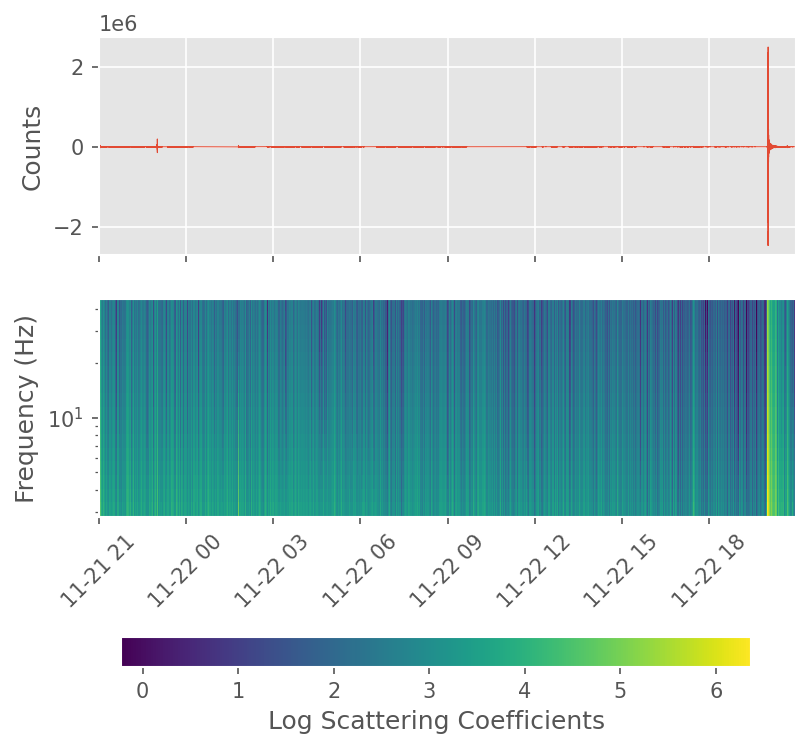

In [17]:
# Extract the first channel
channel_id = 0
trace = streams[0][channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axis
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# Plot the first order scattering coefficients
cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Axis labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
plt.xticks(rotation=45) 

# Add a color bar
fig.subplots_adjust(bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.05])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', label='Log Scattering Coefficients')

# Display the figure
plt.show();


In [18]:
from sklearn.decomposition import FastICA
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))


Collected 2879 samples of 528 dimensions each.


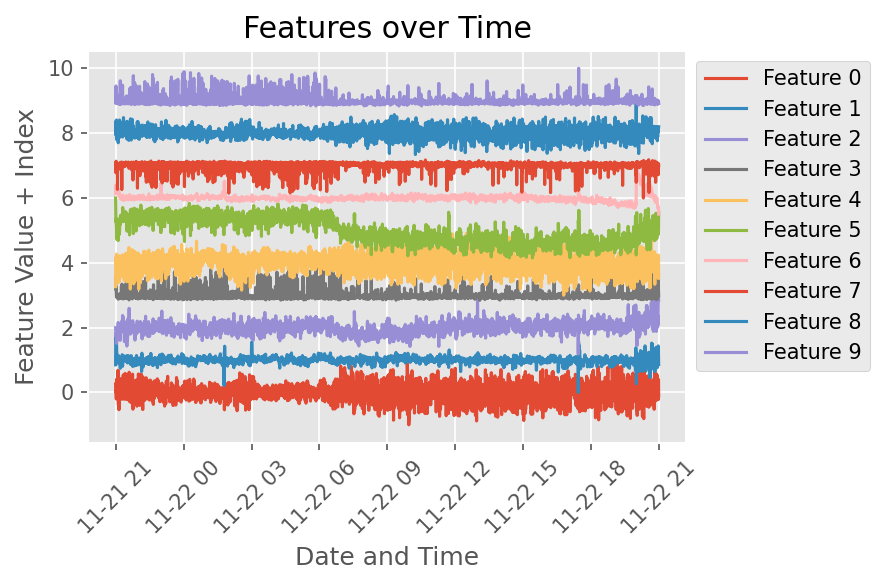

In [19]:
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)

# Normalize features for display purposes
features_normalized = features / np.abs(features).max(axis=0)

# Create a figure instance
plt.style.use('ggplot')
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot each feature
for i in range(features_normalized.shape[1]):
    ax.plot(times, features_normalized[:, i] + i, label=f"Feature {i}");

# Add labels and title
ax.set_title("Features over Time")
ax.set_xlabel("Date and Time")
ax.set_ylabel("Feature Value + Index")

# Adjust x-axis labels
plt.xticks(rotation=45)

# Display a legend to identify which line corresponds to which feature
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Adjust the layout to accommodate the legend
plt.tight_layout()

# Display the plot
plt.show();


KMeans(n_clusters=10, random_state=123)

Text(0.5, 1.0, 'Clusters over Time')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Cluster index')

(array([17126.875, 17127.   , 17127.125, 17127.25 , 17127.375, 17127.5  ,
        17127.625, 17127.75 , 17127.875]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

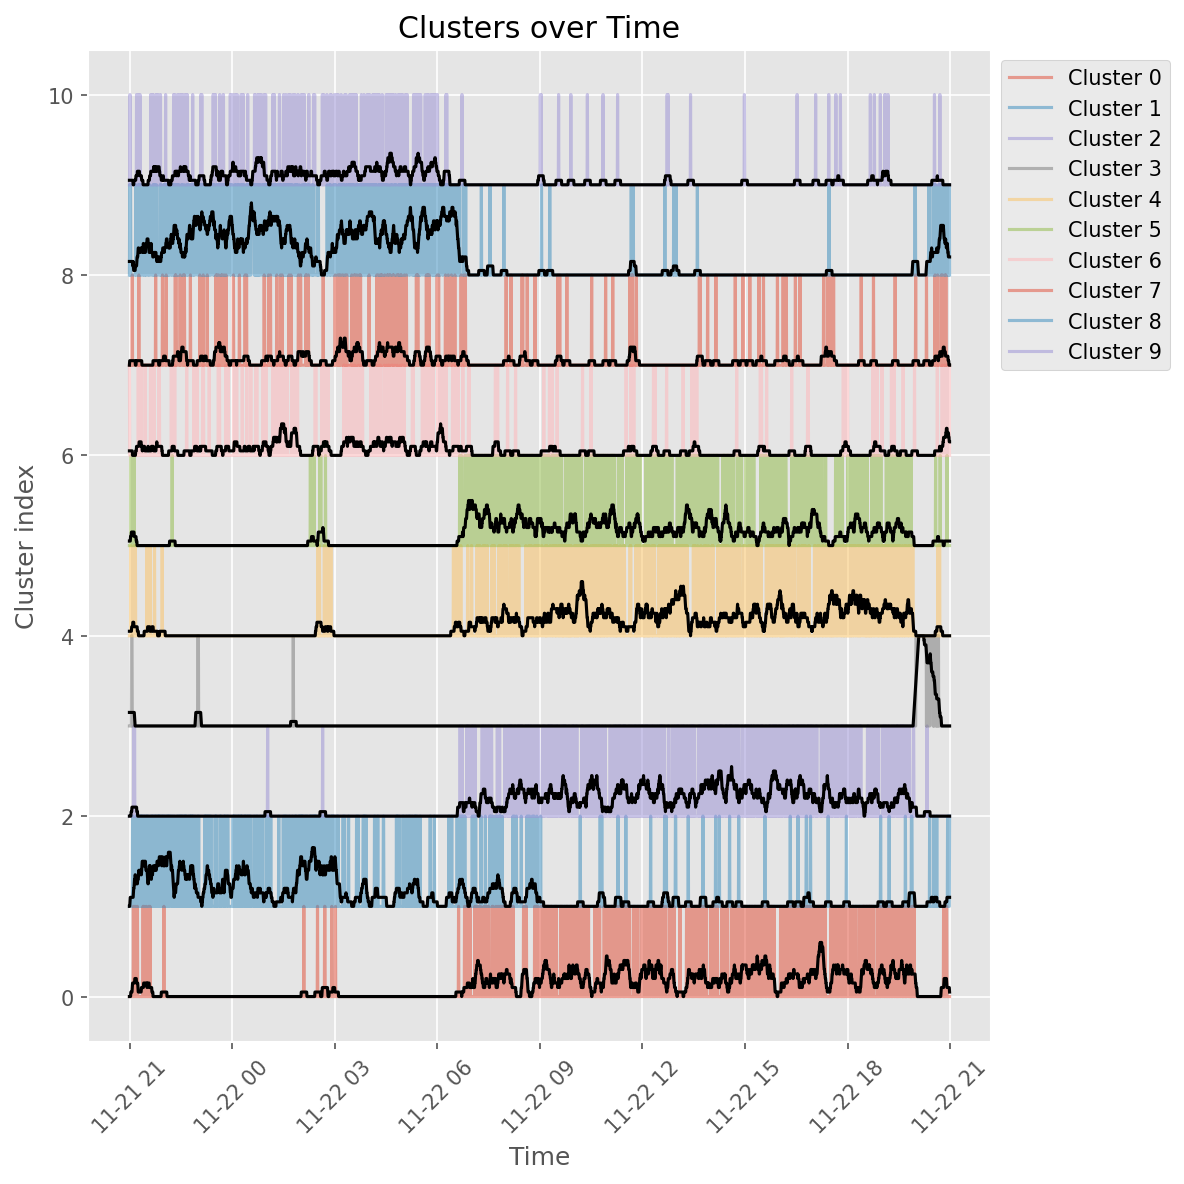

In [21]:
from scipy import signal
from sklearn.cluster import KMeans

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    _=ax.plot(times, one_hot[:, i] + i, alpha=0.5, label=f"Cluster {i}");
    _=ax.plot(times, detection_rate + i, color="black");

# Adding a title for clarity
ax.set_title("Clusters over Time")

# Labels and Legend
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, 'Cluster Centroids Heatmap')

Text(0.5, 70.72222222222221, 'Feature index')

Text(70.72222222222221, 0.5, 'Cluster index')

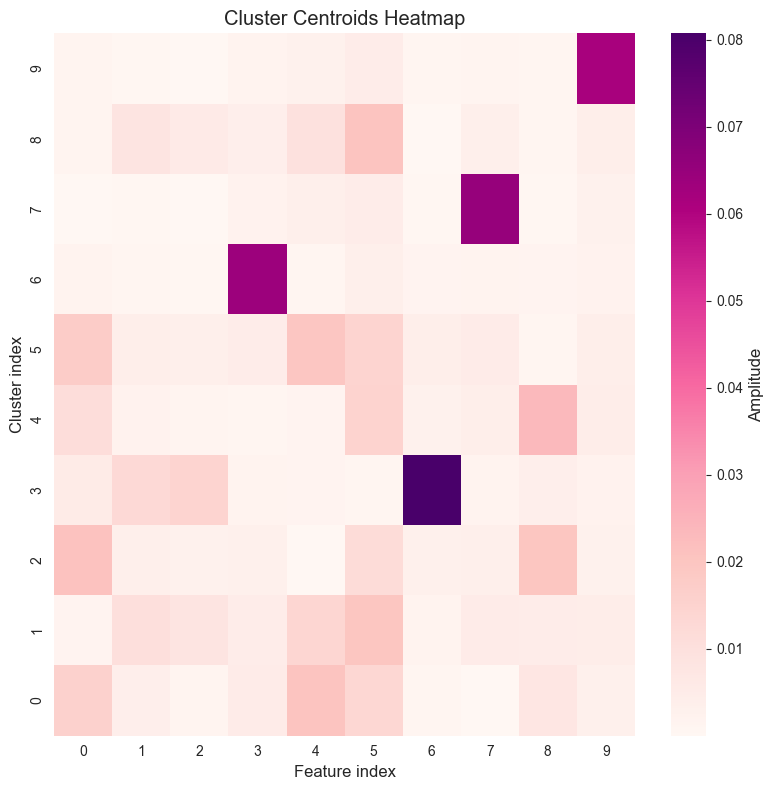

In [22]:
# Get the absolute values of the cluster centers
centroids = np.abs(model.cluster_centers_)

# Use Seaborn for heatmap styling
import seaborn as sns
sns.set_style("white")

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

# Use Seaborn's heatmap function
sns.heatmap(centroids, cmap="RdPu", ax=ax, cbar_kws={"label": "Amplitude"})

# Set the axis titles
ax.set_title("Cluster Centroids Heatmap")
ax.set_xlabel("Feature index")
ax.set_ylabel("Cluster index")

# Invert the y-axis for consistency with original code
ax.invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()



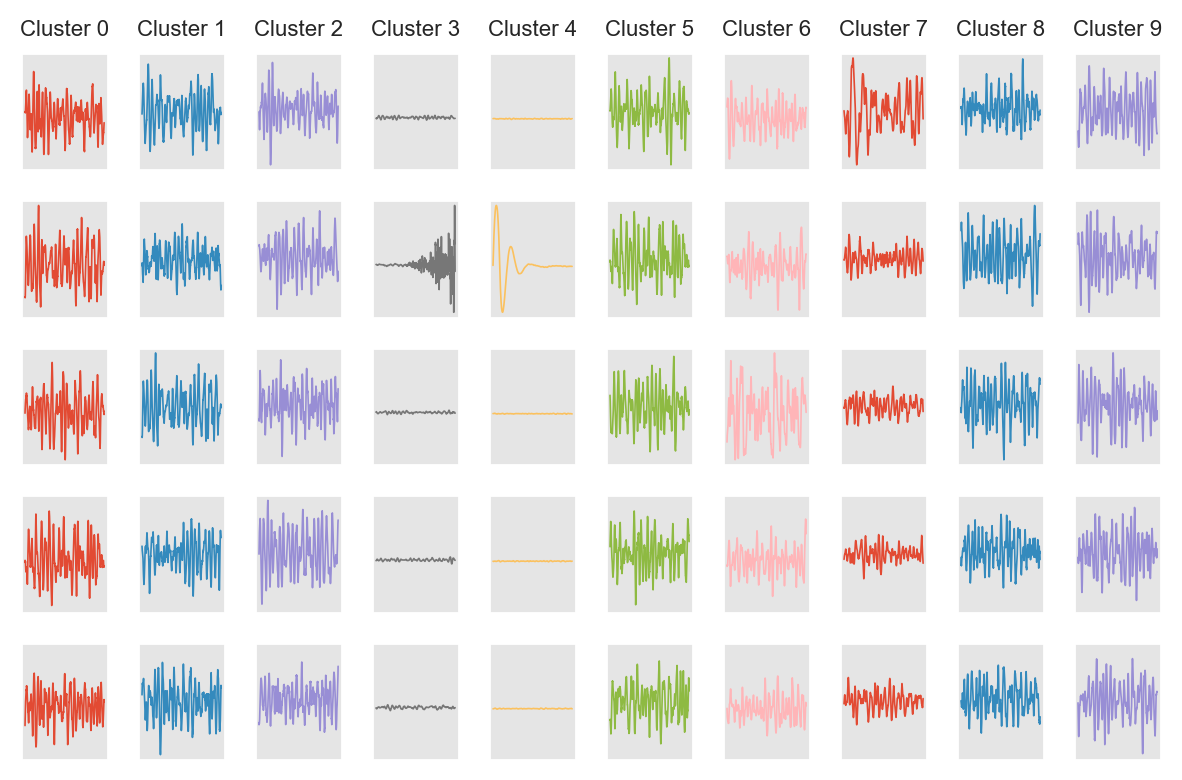

In [25]:
plt.style.use('ggplot')
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = {}
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Get closest samples
    indices = np.argsort(distance)[:N_WAVEFORMS]
    closest_times = [times[i] for i in indices]

    # Collect closest waveforms
    waveforms[cluster] = [stream.slice(UTCDateTime(time), UTCDateTime(time) + waveform_duration)[0].copy() 
                          for time in closest_times]

# Create a figure and a GridSpec layout
fig = plt.figure(dpi=200)
gs = GridSpec(N_WAVEFORMS, N_CLUSTERS, figure=fig)

# Plot each cluster as a separate line
for i, (cluster, traces) in enumerate(waveforms.items()):
    _=ax_main = fig.add_subplot(gs[0, i]);
    _=ax_main.set_title(f"Cluster {cluster}", fontsize=8);  # Adjusted font size here
    _=ax_main.axis('off');
    
    for j, trace in enumerate(traces):
        _=ax = fig.add_subplot(gs[j, i], sharex=ax_main, sharey=ax_main);
        _=ax.plot(trace.times(), trace.data, lw=0.6, color=f"C{i}");
        
        if j < N_WAVEFORMS - 1:  # Hide x-axis for all but the last subplot in each column
            _=ax.set_xticks([]);
        
        _=ax.set_yticks([]);  # Hide y-axis for all subplots

# Adjust the layout
fig.tight_layout()

# Show the figure
plt.show()
